<a href="https://colab.research.google.com/github/GusSampaio/Classificacao_Multirrotulo_no_Dominio_Juridico/blob/main/Minera%C3%A7%C3%A3o_de_Textos_para_Dom%C3%ADnio_Jur%C3%ADdico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Extensionista - Classificação Multirrótulo no Domínio Jurídico

O objetivo deste projeto é desenvolver uma solução de classificação multirrótulo aplicada ao domínio jurídico. Em particular, trabalharemos com processos que podem estar associados a múltiplos assuntos, o que exige uma abordagem específica para lidar com esse tipo de dados.


In [15]:
# Baixando e importando bibliotecas necessarias
%pip install iterative-stratification
%pip install -U sentence-transformers

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Leitura da Base de Dados

In [16]:
!gdown 1E_aecYDw69UgYbgzQCjtP9rWonwpyFuJ
!gdown 1--unYhhi0HoMFT4kNyf91WwckjlTedYo

Downloading...
From (original): https://drive.google.com/uc?id=1E_aecYDw69UgYbgzQCjtP9rWonwpyFuJ
From (redirected): https://drive.google.com/uc?id=1E_aecYDw69UgYbgzQCjtP9rWonwpyFuJ&confirm=t&uuid=ff24e52f-45ee-406f-9820-2f2eaeaf14a5
To: /content/X_train.pkl
  0% 0.00/878M [00:00<?, ?B/s]Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/__main__.py", line 172, in main
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 368, in download
    for chunk in res.iter_content(chunk_size=CHUNK_SIZE):
  File "/usr/local/lib/python3.10/dist-packages/requests/models.py", line 820, in generate
    yield from self.raw.stream(chunk_size, decode_content=True)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 1060, in stream
    data = self.read(amt=amt, decode_content=decode_content)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response

In [26]:
X_train = pd.read_pickle("X_train.pkl")
y_train = pd.read_pickle("Y_train.pkl")

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

## Análise Exploratória Descritiva

In [27]:
X_train.head()

,texto
0,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. SERVID...
1,DECISÃO: - Vistos. Trata-se de agravo regiment...
2,DECISÃO: O Tribunal a quo assim dirimiu a cont...
3,DECISÃO EMBARGOS DECLARATÓRIOS – OMISSÃO. 1. P...
4,"DECISÃO: 1. Trata-se de habeas corpus,..."


In [28]:
x_train_size = X_train.shape[0]
print("Tamanho do conjunto de treino:",x_train_size,'textos diferentes')

Tamanho do conjunto de treino: 220457 textos diferentes


In [29]:
y_train.head()

,DIREITO DO TRABALHO,SISTEMA REMUNERATORIO E BENE,RMI RENDA MENSAL INICIAL REAJUSTES E REVISOES ESPECIFICAS,ATOS PROCESSUAIS,RESPONSABILIDADE CIVIL,COFINSDIREITO TRIBUTARIO,DIREITO PROCESSUAL PENAL,ATOS ADMINISTRATIVOS,CONTRIBUICOES PREVIDENCIARIAS,LIMITACOES AO PODER DE TRIBUTAR,...,CRIMES DE LAVAGEM OU OCULTACAO DE BE,DIREITO ADMINISTRATIVO E OUTRAS MATERIAS DE DIREITO PUBLICO,APOSENTADORIA,RESCISAO DO CONTRATO DE TRABALHO,CRIMES PREVISTOS NA LEGISLACAO EXTRAVAGANTE,BENEFICIOS EM ESPECIE,PARTES E PROCURADORES,MAGISTRATURA,PRISAO PREVENTIVA,EXCESSO DE PRAZO PARA INSTRUCAO / JULGAMENTO
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
print("Exemplo de texto jurídico:")
display(X_train.loc[0].texto)

print("\nClasses atribuídas a ele:")
for index, row in pd.DataFrame(y_train.loc[0]).iterrows():
  if row[0] != 0:
    print(row.name)

Exemplo de texto jurídico:


'EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. SERVIDOR PÚBLICO. LICENÇA-GESTANTE. EXONERAÇÃO. C.F., art. 7º, XVIII; ADCT, art. 10, II, b. I. - Servidora exonerada quando no gozo de licença-gestante: a exoneração constitui ato arbitrário, porque contrária à norma constitucional: C.F., art. 7º, XVIII; ADCT, art. 10, II, b. II. Negativa de trânsito ao RE. DECISÃO: - Vistos. Assim a ementa do acórdão recorrido da 2ª Câmara Especializada Cível do Tribunal de Justiça do Estado do Piauí: "A servidora pública, ainda que não concursada, não pode ser demitida no período dos cinco meses após o parto, porquanto amparado pela ESTABILIADE PROVISÓRIA, assegurada constitucionalmente a toda e qualquer trabalhadora-mãe, independentemente do regime jurídico de trabalho, principalmente quando comprovada a sua condição de contribuinte da Previdência Social do Estado - IAPEP. Decisão unânime, de acordo com o parecer ministerial" (fl. 130). Daí o RE, interposto pelo ESTADO DO PIAUÍ, fundado no art. 102, III, a, d


Classes atribuídas a ele:
REGIME ESTATU
SERVIDOR PUBLICO CIVIL
DIREITO ADMINISTRATIVO E OUTRAS MATERIAS DE DIREITO PUBLICO


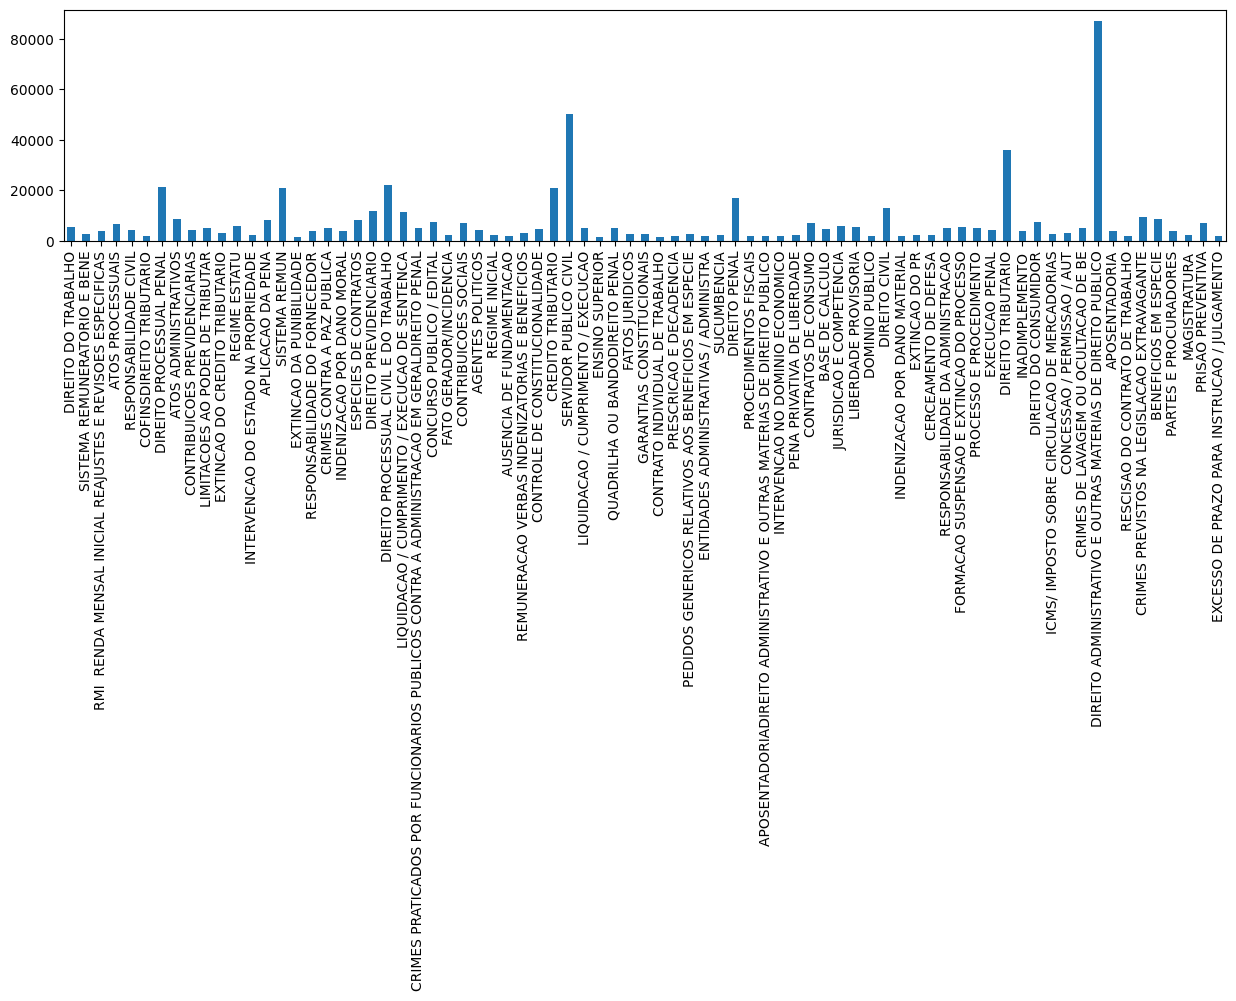

In [31]:
# Distribuição das classes.
y_train.sum().plot.bar(figsize=(15, 3))
plt.show()

# Separando um conjunto de validação

In [32]:
mskf = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=0)

splits = list(mskf.split(X_train, y_train))
train_index, val_index = splits[0]

X_train, X_val = X_train.loc[train_index], X_train.loc[val_index]
y_train, y_val = y_train.loc[train_index], y_train.loc[val_index]

In [33]:
len(y_train), len(y_val)

(110186, 110271)

# Pré-processamento



In [34]:
# Criando representações vetoriais (em formato de matriz TF-IDF) a partir dos textos
nltk.download("stopwords")

vectorizer = TfidfVectorizer(
    stop_words=stopwords.words("portuguese"),
    min_df=5
)

X_train_tf = vectorizer.fit_transform(X_train.texto.to_list())
X_val_tf = vectorizer.transform(X_val.texto.to_list())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [37]:
# Instanciando modelo gerador de embeddings multilinguais
multilingual_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

X_train_multilingual_embeddings = multilingual_model.encode(
    X_train.texto.to_list(),
    show_progress_bar=True,
    normalize_embeddings=True
)

X_val_multilingual_embeddings = multilingual_model.encode(
    X_val.texto.to_list(),
    show_progress_bar=True,
    normalize_embeddings=True
)

Batches:   0%|          | 0/3444 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Instanciando modelo gerador de embeddings em PT-BR
pt_model = SentenceTransformer("pierreguillou/bert-base-cased-pt-lenerbr")

X_train_pt_embeddings = pt_model.encode(
    X_train.texto.to_list(),
    show_progress_bar=True,
    normalize_embeddings=True
)

X_val_pt_embeddings = pt_model.encode(
    X_val.texto.to_list(),
    show_progress_bar=True,
    normalize_embeddings=True
)

config.json:   0%|          | 0.00/893 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at pierreguillou/bert-base-cased-pt-lenerbr and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/530 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/438k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

#Treinamento dos Modelos

In [ ]:
class_weights = {}
for col in y_train.columns:
    weights = compute_class_weight(
        class_weight="balanced",
        classes=np.array([0, 1]),
        y=y_train[col].values
    )
    class_weights[col] = dict(enumerate(weights))

print("Pesos para cada classe:", class_weights)

Pesos para cada classe: {'DIREITO DO TRABALHO': {0: 0.5126885602881098, 1: 20.202786945361204}, 'SISTEMA REMUNERATORIO E BENE': {0: 0.5064486178906631, 1: 39.2679971489665}, 'RMI  RENDA MENSAL INICIAL REAJUSTES E REVISOES ESPECIFICAS': {0: 0.509026905166679, 1: 28.194984646878197}, 'ATOS PROCESSUAIS': {0: 0.5150804038893044, 1: 17.0778053316801}, 'RESPONSABILIDADE CIVIL': {0: 0.5101062007536827, 1: 25.23728813559322}, 'COFINSDIREITO TRIBUTARIO': {0: 0.50431606601796, 1: 58.42311770943797}, 'DIREITO PROCESSUAL PENAL': {0: 0.5535315985130111, 1: 5.170138888888889}, 'ATOS ADMINISTRATIVOS': {0: 0.5201476613984403, 1: 12.90838800374883}, 'CONTRIBUICOES PREVIDENCIARIAS': {0: 0.5100117567555058, 1: 25.470642625982432}, 'LIMITACOES AO PODER DE TRIBUTAR': {0: 0.5116220759079891, 1: 22.01078705553336}, 'EXTINCAO DO CREDITO TRIBUTARIO': {0: 0.5066954842269843, 1: 37.8385989010989}, 'REGIME ESTATU': {0: 0.5136349651783966, 1: 18.835213675213677}, 'INTERVENCAO DO ESTADO NA PROPRIEDADE': {0: 0.50548

In [ ]:
# Definir o número de atributos e classes
n_features = X_train_bow.shape[1]
n_classes = y_train.shape[1]

# Construção da rede neural
model_multilingual_embeddings = Sequential([
    Input(shape=(n_features,), sparse=True),
    Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(n_classes, activation="sigmoid")  # Camada de saída para multirrótulo
])

# Compilação do modelo
model_multilingual_embeddings.compile(
    optimizer=Adam(learning_rate=0.001),  # Taxa de aprendizado inicial ajustada
    loss="binary_crossentropy",  # Perda para multirrótulo
    metrics=["accuracy"]  # Métricas adicionais podem ser adicionadas
)

# Callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,  # Para evitar treinar por muito tempo
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,  # Reduz a taxa de aprendizado se o modelo parar de melhorar
    min_lr=1e-6
)

# Treinamento
history = model_multilingual_embeddings.fit(
    X_train_bow, y_train,
    validation_data=(X_val_bow, y_val),
    epochs=100,  # Aumentei o número de épocas, mas o EarlyStopping evita overfitting
    batch_size=32,
    class_weight=class_weights,  # Pesos ajustados para classes desbalanceadas
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
 237/3444 ━━━━━━━━━━━━━━━━━━━━ 19:15 360ms/step - accuracy: 0.0401 - loss: 1.0236

KeyboardInterrupt: 